In [4]:
# ARC Competition Starter Notebook
# This notebook helps you get started with the Abstract Reasoning competition

import json
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Dict, Tuple
import random
from pathlib import Path
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from typing import List, Dict
import time

print("✅ Packages installed and imported")
print("🎯 ARC Competition Starter Notebook")
print("="*50)

✅ Packages installed and imported
🎯 ARC Competition Starter Notebook


In [5]:
import os
import json

def load_training_tasks(data_dir='data/training'):
    tasks = []
    for fname in os.listdir(data_dir):
        if fname.endswith('.json'):
            with open(os.path.join(data_dir, fname), 'r') as f:
                tasks.append(json.load(f))
    return tasks

train_data = load_training_tasks()
print(f"✓ Loaded {len(train_data)} training problems")

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'data/training'

In [ ]:
print("\n📊 Data Format Overview")
print("="*50)

# Get a sample problem
sample_problem_id = list(train_data.keys())[0]
sample_problem = train_data[sample_problem_id]

print(f"\nSample Problem ID: {sample_problem_id}")
print(f"Number of training examples: {len(sample_problem['train'])}")
print(f"Number of test examples: {len(sample_problem['test'])}")

# Show structure
print("\nProblem Structure:")
print("- Each problem has 'train' examples showing input→output transformations")
print("- Each problem has 'test' examples where you predict the output")
print("- Grid values are integers 0-9 representing different colors")

# Show grid sizes
train_ex = sample_problem['train'][0]
print(f"\nFirst training example:")
print(f"  Input shape: {len(train_ex['input'])}x{len(train_ex['input'][0])}")
print(f"  Output shape: {len(train_ex['output'])}x{len(train_ex['output'][0])}")


📊 Data Format Overview

Sample Problem ID: train_0000
Number of training examples: 3
Number of test examples: 1

Problem Structure:
- Each problem has 'train' examples showing input→output transformations
- Each problem has 'test' examples where you predict the output
- Grid values are integers 0-9 representing different colors

First training example:
  Input shape: 22x21
  Output shape: 9x9



🎨 Visualizing a sample problem:


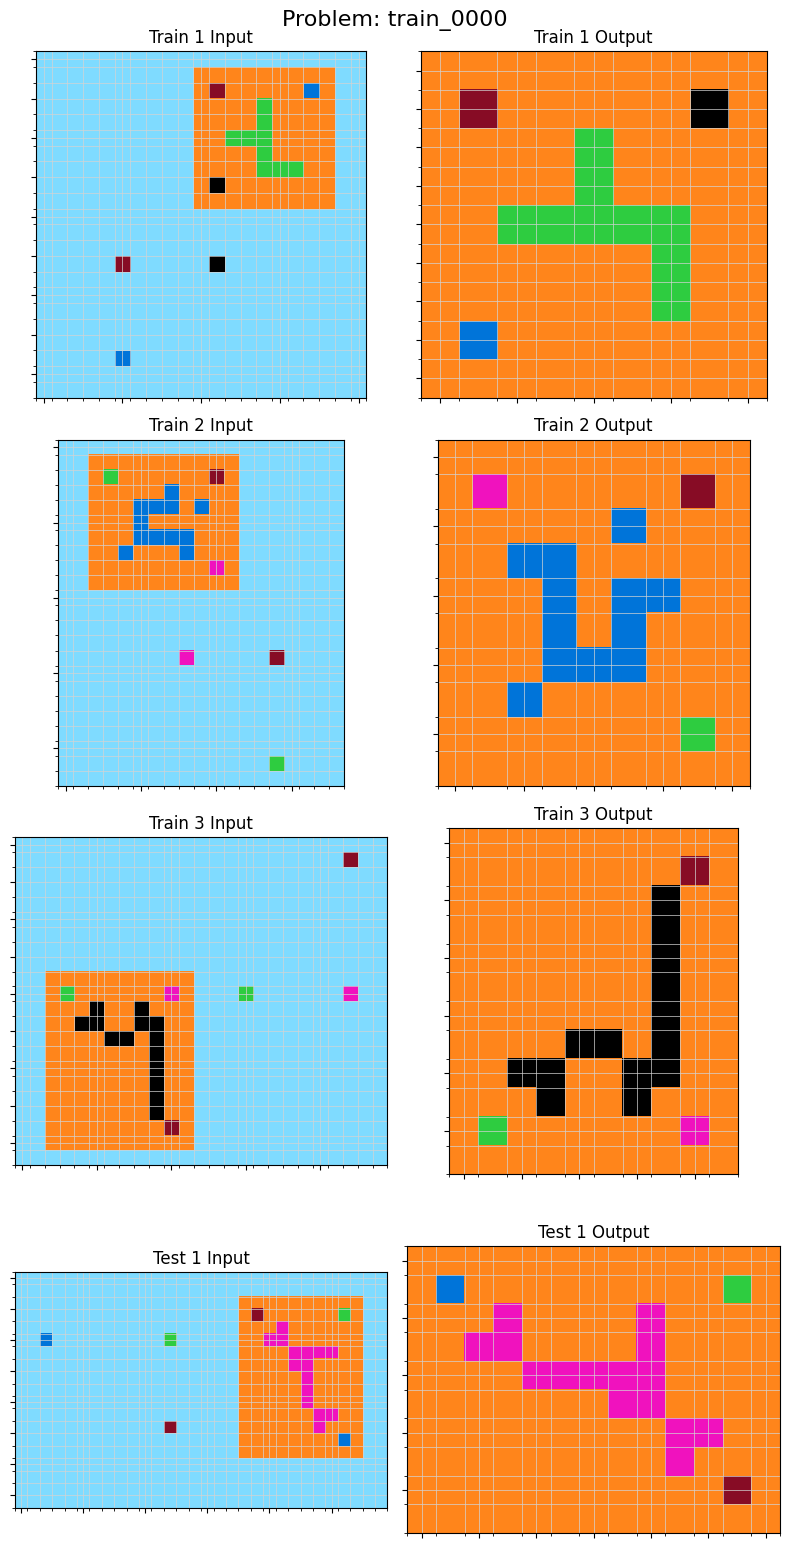

In [ ]:
def plot_grid(grid, ax, title):
    """Plot a single grid"""
    # Color palette for ARC (0-9)
    colors = ['#000000', '#0074D9', '#FF4136', '#2ECC40', '#FFDC00',
              '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25']
    cmap = plt.matplotlib.colors.ListedColormap(colors)

    ax.imshow(grid, cmap=cmap, vmin=0, vmax=9)
    ax.set_title(title)
    ax.grid(True, which='both', color='lightgray', linewidth=0.5)
    ax.set_xticks(np.arange(-0.5, len(grid[0]), 1), minor=True)
    ax.set_yticks(np.arange(-0.5, len(grid), 1), minor=True)
    ax.set_xticklabels([])
    ax.set_yticklabels([])

def visualize_problem(problem_data, problem_id, max_examples=3):
    """Visualize a complete problem"""
    n_train = min(len(problem_data['train']), max_examples)
    n_test = len(problem_data['test'])

    fig, axes = plt.subplots(n_train + n_test, 2, figsize=(8, 4*(n_train+n_test)))
    if n_train + n_test == 1:
        axes = axes.reshape(1, -1)

    # Plot training examples
    for i in range(n_train):
        plot_grid(problem_data['train'][i]['input'], axes[i, 0], f'Train {i+1} Input')
        plot_grid(problem_data['train'][i]['output'], axes[i, 1], f'Train {i+1} Output')

    # Plot test examples
    for i in range(n_test):
        row = n_train + i
        plot_grid(problem_data['test'][i]['input'], axes[row, 0], f'Test {i+1} Input')

        # For test, we need to predict the output
        if 'output' in problem_data['test'][i]:
            # Training data has solutions
            plot_grid(problem_data['test'][i]['output'], axes[row, 1], f'Test {i+1} Output')
        else:
            # Test data - no solution
            axes[row, 1].text(0.5, 0.5, '?', ha='center', va='center', fontsize=50)
            axes[row, 1].set_title(f'Test {i+1} Output (Predict this!)')
            axes[row, 1].axis('off')

    plt.suptitle(f'Problem: {problem_id}', fontsize=16)
    plt.tight_layout()
    plt.show()

# Visualize a sample problem
print("\n🎨 Visualizing a sample problem:")
visualize_problem(sample_problem, sample_problem_id)

In [ ]:
def analyze_transformation(input_grid, output_grid):
    """Analyze the transformation between input and output"""
    input_arr = np.array(input_grid)
    output_arr = np.array(output_grid)

    analysis = {
        'size_change': {
            'input_shape': input_arr.shape,
            'output_shape': output_arr.shape,
            'same_size': input_arr.shape == output_arr.shape
        },
        'colors': {
            'input_colors': sorted(list(set(input_arr.flatten()))),
            'output_colors': sorted(list(set(output_arr.flatten()))),
        }
    }

    # Check for simple transformations
    if analysis['size_change']['same_size']:
        # Check rotations
        if np.array_equal(output_arr, np.rot90(input_arr, 1)):
            analysis['transformation'] = 'rotate_90'
        elif np.array_equal(output_arr, np.rot90(input_arr, 2)):
            analysis['transformation'] = 'rotate_180'
        elif np.array_equal(output_arr, np.rot90(input_arr, 3)):
            analysis['transformation'] = 'rotate_270'
        elif np.array_equal(output_arr, np.fliplr(input_arr)):
            analysis['transformation'] = 'flip_horizontal'
        elif np.array_equal(output_arr, np.flipud(input_arr)):
            analysis['transformation'] = 'flip_vertical'
        else:
            analysis['transformation'] = 'complex'
    else:
        analysis['transformation'] = 'size_change'

    return analysis

# Analyze the sample problem
print("\n🔍 Analyzing transformations in sample problem:")
for i, example in enumerate(sample_problem['train'][:2]):
    analysis = analyze_transformation(example['input'], example['output'])
    print(f"\nTraining example {i+1}:")
    print(f"  Input shape: {analysis['size_change']['input_shape']}")
    print(f"  Output shape: {analysis['size_change']['output_shape']}")
    print(f"  Transformation type: {analysis['transformation']}")


🔍 Analyzing transformations in sample problem:

Training example 1:
  Input shape: (22, 21)
  Output shape: (9, 9)
  Transformation type: size_change

Training example 2:
  Input shape: (23, 19)
  Output shape: (10, 9)
  Transformation type: size_change


In [ ]:



def grid_to_text(grid: List[List[int]]) -> str:
    """Convert a numeric grid to text representation"""
    lines = []
    for row in grid:
        row_str = ' '.join(str(cell) for cell in row)
        lines.append(row_str)
    return '\n'.join(lines)

def text_to_grid(text: str) -> List[List[int]]:
    """Convert text back to numeric grid"""
    try:
        lines = text.strip().split('\n')
        grid = []

        for line in lines:
            # Clean the line and extract numbers
            cleaned = line.strip()
            if cleaned and any(c.isdigit() for c in cleaned):
                # Extract all numbers from the line
                numbers = []
                current_num = ''

                for char in cleaned + ' ':
                    if char.isdigit():
                        current_num += char
                    elif current_num:
                        numbers.append(int(current_num))
                        current_num = ''

                if numbers:
                    grid.append(numbers)

        return grid if grid else [[0]]
    except Exception as e:
        print(f"Error parsing grid: {e}")
        return [[0]]

# Test the conversion functions
test_grid = [[1, 2, 3], [4, 5, 6], [7, 8, 9]]
text_repr = grid_to_text(test_grid)
back_to_grid = text_to_grid(text_repr)
print(f"\n✅ Grid conversion test: {test_grid == back_to_grid}")


✅ Grid conversion test: True


In [ ]:
class DummyARCModel:
    """
    Dummy model that simulates an ARC solver.
    Replace this with your actual model implementation!
    """

    def __init__(self, model_name="dummy-model", verbose=True):
        self.model_name = model_name
        self.verbose = verbose
        print(f"🤖 Initialized {model_name} (dummy model)")
        print("   ⚠️  This is a placeholder - implement your own logic!")

        # Simulate model loading time
        time.sleep(0.5)
        print("   ✓ Model 'loaded' successfully")

    def create_prompt(self, problem: Dict) -> str:
        """
        Create a prompt from the problem.
        Customize this for your model!
        """
        prompt = "Solve this pattern recognition puzzle:\n\n"

        # Add training examples
        for i, example in enumerate(problem['train'], 1):
            prompt += f"Example {i}:\n"
            prompt += f"Input:\n{grid_to_text(example['input'])}\n"
            prompt += f"Output:\n{grid_to_text(example['output'])}\n\n"

        # Add test case
        prompt += "Test Input:\n"
        prompt += f"{grid_to_text(problem['test'][0]['input'])}\n"
        prompt += "Test Output:\n"

        return prompt

    def solve(self, problem: Dict) -> List[List[int]]:
        """
        Solve an ARC problem.
        This is where you implement your solving logic!
        """
        # Create prompt (you might use this for an LLM)
        prompt = self.create_prompt(problem)

        if self.verbose:
            print(f"  Prompt length: {len(prompt)} chars")

        # Simulate thinking time
        time.sleep(random.uniform(0.1, 0.3))

        # ====================================
        # DUMMY SOLVING STRATEGIES
        # Replace these with your actual implementation!
        # ====================================

        strategy = random.choice(['copy', 'rotate', 'flip', 'tile'])
        test_input = problem['test'][0]['input']

        if strategy == 'copy':
            # Strategy 1: Just copy the input
            return test_input

        elif strategy == 'rotate':
            # Strategy 2: Rotate 90 degrees
            return np.rot90(test_input, k=1).tolist()

        elif strategy == 'flip':
            # Strategy 3: Flip horizontally
            return np.fliplr(test_input).tolist()

        elif strategy == 'tile':
            # Strategy 4: Tile 2x2 (if small enough)
            if len(test_input) <= 15 and len(test_input[0]) <= 15:
                return np.tile(test_input, (2, 2)).tolist()
            else:
                return test_input

        # Default: return input unchanged
        return test_input

# Initialize your model here
model = DummyARCModel(model_name="my-arc-solver", verbose=True)


def evaluate_on_training(model, train_data, num_examples=5):
    """Evaluate model on training examples"""
    correct = 0
    total = 0

    print(f"\n🧪 Testing on {num_examples} training examples...")

    for i, (problem_id, problem) in enumerate(train_data.items()):
        if i >= num_examples:
            break

        print(f"\nProblem {i+1}/{num_examples} (ID: {problem_id}):")

        # Create test version
        test_version = {
            'train': problem['train'],
            'test': [{'input': problem['test'][0]['input']}]
        }

        # Solve
        start_time = time.time()
        prediction = model.solve(test_version)
        solve_time = time.time() - start_time

        # Check if correct
        expected = problem['test'][0]['output']
        is_correct = (prediction == expected)

        if is_correct:
            correct += 1
        total += 1

        print(f"  Time: {solve_time:.2f}s")
        print(f"  Correct: {'✅' if is_correct else '❌'}")

        # Show shapes
        try:
            print(f"  Expected shape: {len(expected)}x{len(expected[0])}")
            print(f"  Predicted shape: {len(prediction)}x{len(prediction[0])}")
        except:
            print(f"  Shape error in prediction")

    accuracy = correct / total if total > 0 else 0
    print(f"\n📊 Accuracy: {accuracy:.1%} ({correct}/{total})")
    return accuracy

🤖 Initialized my-arc-solver (dummy model)
   ⚠️  This is a placeholder - implement your own logic!
   ✓ Model 'loaded' successfully


In [ ]:

# Test the model
accuracy = evaluate_on_training(model, train_data, num_examples=5)


🧪 Testing on 5 training examples...

Problem 1/5 (ID: train_0000):
  Prompt length: 4766 chars
  Time: 0.23s
  Correct: ❌
  Expected shape: 10x13
  Predicted shape: 19x30

Problem 2/5 (ID: train_0001):
  Prompt length: 5601 chars
  Time: 0.20s
  Correct: ❌
  Expected shape: 2x5
  Predicted shape: 30x30

Problem 3/5 (ID: train_0002):
  Prompt length: 1064 chars
  Time: 0.13s
  Correct: ❌
  Expected shape: 12x12
  Predicted shape: 3x3

Problem 4/5 (ID: train_0003):
  Prompt length: 5766 chars
  Time: 0.25s
  Correct: ❌
  Expected shape: 22x27
  Predicted shape: 22x27

Problem 5/5 (ID: train_0004):
  Prompt length: 7010 chars
  Time: 0.11s
  Correct: ❌
  Expected shape: 24x22
  Predicted shape: 22x24

📊 Accuracy: 0.0% (0/5)


In [ ]:
def create_submission(test_data, model, output_file='submission.json', csv_file='submission.csv'):
    """Create submission files in both JSON and CSV formats"""
    submission_json = {}
    submission_csv = []
    total = len(test_data)

    print(f"\n📝 Generating submission for {total} test problems...")

    for i, (problem_id, problem) in enumerate(test_data.items()):
        # Progress update
        if (i + 1) % 10 == 0:
            print(f"  Progress: {i+1}/{total} ({(i+1)/total*100:.1f}%)")

        try:
            # Check how many test cases this problem has
            num_test_cases = len(problem['test'])
            predictions = []

            # Solve each test case
            for test_idx in range(num_test_cases):
                # Create a version with just this test case
                single_test_problem = {
                    'train': problem['train'],
                    'test': [problem['test'][test_idx]]
                }

                # Solve this test case
                prediction = model.solve(single_test_problem)

                if isinstance(prediction, list) and len(prediction) > 0:
                    predictions.append(prediction)
                else:
                    # Fallback to input
                    predictions.append(problem['test'][test_idx]['input'])

            # JSON format stores all predictions
            submission_json[problem_id] = predictions

            # CSV format: each matrix and each row gets its own CSV row
            for matrix_idx, prediction in enumerate(predictions):
                matrix_num = matrix_idx + 1  # Start from 1

                for row_idx, row in enumerate(prediction):
                    row_num = row_idx + 1  # Start from 1

                    # Convert row values to string
                    row_string = ''.join(str(cell) for cell in row)

                    # Create ID with matrix and row indices
                    if num_test_cases > 1:
                        # Multiple test cases: include matrix index
                        csv_id = f"{problem_id}_{matrix_num}_{row_num}"
                    else:
                        # Single test case: just row index
                        csv_id = f"{problem_id}_{row_num}"

                    submission_csv.append({
                        'ID': csv_id,
                        'row': row_string
                    })

        except Exception as e:
            print(f"  Error on {problem_id}: {e}")
            # Fallback: submit inputs as outputs
            fallback_predictions = []
            for test_case in problem['test']:
                fallback_predictions.append(test_case['input'])

            submission_json[problem_id] = fallback_predictions

            # Create CSV rows for fallback
            for matrix_idx, input_grid in enumerate(fallback_predictions):
                matrix_num = matrix_idx + 1
                for row_idx, row in enumerate(input_grid):
                    row_num = row_idx + 1
                    row_string = ''.join(str(cell) for cell in row)

                    if len(fallback_predictions) > 1:
                        csv_id = f"{problem_id}_{matrix_num}_{row_num}"
                    else:
                        csv_id = f"{problem_id}_{row_num}"

                    submission_csv.append({
                        'ID': csv_id,
                        'row': row_string
                    })

    # Save JSON submission
    with open(output_file, 'w') as f:
        json.dump(submission_json, f, separators=(',', ':'))

    # Save CSV submission
    import csv
    with open(csv_file, 'w', newline='') as f:
        writer = csv.DictWriter(f, fieldnames=['ID', 'row'])
        writer.writeheader()
        writer.writerows(submission_csv)

    print(f"\n✅ Submissions saved:")
    print(f"   JSON format: {output_file}")
    print(f"   CSV format: {csv_file}")
    print(f"   Total problems: {len(submission_json)}")
    print(f"   Total CSV rows: {len(submission_csv)}")

    # Show sample of CSV format
    if submission_csv:
        print(f"\nSample CSV entries (first 10 rows):")
        for i in range(min(10, len(submission_csv))):
            print(f"   {submission_csv[i]['ID']}: {submission_csv[i]['row']}")

    # Show example of multi-test problem
    multi_test_problems = [p for p in test_data.items() if len(p[1]['test']) > 1]
    if multi_test_problems:
        example_id, example_prob = multi_test_problems[0]
        print(f"\n📐 Example multi-test problem '{example_id}':")
        print(f"   Number of test cases: {len(example_prob['test'])}")
        if example_id in submission_json:
            for i, pred in enumerate(submission_json[example_id]):
                print(f"   Matrix {i+1}: {len(pred)}x{len(pred[0])} ({len(pred)} rows)")

    return submission_json, submission_csv

# Generate the submission
submission_json, submission_csv = create_submission(test_data, model)



📝 Generating submission for 200 test problems...
  Prompt length: 2200 chars
  Prompt length: 5606 chars
  Prompt length: 1138 chars
  Prompt length: 4352 chars
  Prompt length: 1567 chars
  Prompt length: 2674 chars
  Prompt length: 2162 chars
  Prompt length: 1860 chars
  Prompt length: 5200 chars
  Prompt length: 4916 chars
  Prompt length: 4834 chars
  Progress: 10/200 (5.0%)
  Prompt length: 2114 chars
  Prompt length: 704 chars
  Prompt length: 3010 chars
  Prompt length: 11920 chars
  Prompt length: 1711 chars
  Prompt length: 429 chars
  Prompt length: 1119 chars
  Prompt length: 1326 chars
  Prompt length: 3990 chars
  Prompt length: 2131 chars
  Progress: 20/200 (10.0%)
  Prompt length: 889 chars
  Prompt length: 6473 chars
  Prompt length: 7023 chars
  Prompt length: 1604 chars
  Prompt length: 3352 chars
  Prompt length: 1546 chars
  Prompt length: 3152 chars
  Prompt length: 370 chars
  Prompt length: 6042 chars
  Prompt length: 4051 chars
  Prompt length: 4631 chars
  Pr

In [ ]:
import pandas as pd
pd.read_csv('submission.csv').head()

,ID,row
0,test_0000_1,8888888888888
1,test_0000_2,8888888888888
2,test_0000_3,8878778787788
3,test_0000_4,8878888888788
4,test_0000_5,8888888888888


In [ ]:
#  Implementation Guide
# ============================================
print("\n" + "="*60)
print("📚 IMPLEMENTATION GUIDE")
print("="*60)

implementation_guide = """
To create your own ARC solver:

1. **Replace the DummyARCModel class** with your implementation:
   - Use a language model (GPT, Claude, Llama, Qwen, etc.)
   - Implement pattern recognition algorithms
   - Use computer vision techniques
   - Try program synthesis approaches

2. **Key methods to implement**:

   ```python
   class YourARCModel:
       def __init__(self):
           # Load your model here
           pass

       def solve(self, problem):
           # Your solving logic
           # Input: problem dict with 'train' and 'test'
           # Output: predicted grid (list of lists)
           return prediction
   ```

3. **Example: Using a Language Model**:

   ```python
   from transformers import AutoModelForCausalLM, AutoTokenizer

   class LLMARCModel:
       def __init__(self, model_name):
           self.tokenizer = AutoTokenizer.from_pretrained(model_name)
           self.model = AutoModelForCausalLM.from_pretrained(model_name)

       def solve(self, problem):
           prompt = self.create_prompt(problem)
           # Generate with your model
           # Parse output to grid
           return predicted_grid
   ```

4. **Example: Pattern Matching**:

   ```python
   class PatternARCModel:
       def solve(self, problem):
           # Analyze training examples
           pattern = self.detect_pattern(problem['train'])

           # Apply pattern to test
           prediction = self.apply_pattern(
               problem['test'][0]['input'],
               pattern
           )
           return prediction
   ```

5. **Tips**:
   - Start simple (rotations, flips, color mappings)
   - Test on training data before submitting
   - Handle edge cases (different grid sizes, etc.)
   - Consider ensemble approaches

Good luck! 🎯
"""

print(implementation_guide)



📚 IMPLEMENTATION GUIDE

To create your own ARC solver:

1. **Replace the DummyARCModel class** with your implementation:
   - Use a language model (GPT, Claude, Llama, Qwen, etc.)
   - Implement pattern recognition algorithms
   - Use computer vision techniques
   - Try program synthesis approaches

2. **Key methods to implement**:
   
   ```python
   class YourARCModel:
       def __init__(self):
           # Load your model here
           pass
       
       def solve(self, problem):
           # Your solving logic
           # Input: problem dict with 'train' and 'test'
           # Output: predicted grid (list of lists)
           return prediction
   ```

3. **Example: Using a Language Model**:
   
   ```python
   from transformers import AutoModelForCausalLM, AutoTokenizer
   
   class LLMARCModel:
       def __init__(self, model_name):
           self.tokenizer = AutoTokenizer.from_pretrained(model_name)
           self.model = AutoModelForCausalLM.from_pretrained(model_name)


In [ ]:

print("\n" + "="*60)
print("🚀 NEXT STEPS")
print("="*60)
print("""
1. Implement your own model by replacing DummyARCModel
2. Test on training data to measure accuracy
3. Generate submission for test data
4. Submit your results!

Remember: The dummy model uses random strategies.
Your implementation should analyze the patterns properly!
""")


🚀 NEXT STEPS

1. Implement your own model by replacing DummyARCModel
2. Test on training data to measure accuracy
3. Generate submission for test data
4. Submit your results!

Remember: The dummy model uses random strategies.
Your implementation should analyze the patterns properly!

